In [110]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.offsets import BDay

from CUSIP_Curve import CUSIP_Curve
from models.MonotoneConvex import MonotoneConvex
from utils.utils import quantlib_date_to_pydatetime

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cusip_curve_builder = CUSIP_Curve(use_ust_issue_date=True, no_logs_plz=True)

In [274]:
as_of_date = datetime(2024, 8, 2)
quote_type = "bid"

curve_set_df = cusip_curve_builder.build_curve_set(
    as_of_date=as_of_date,
    sorted=True, 
    use_github=True, 
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"]
)
curve_set_df

,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,security_term,original_security_term,bid_price,bid_yield,rank
0,912797KW6,Bill,2024-07-03,2024-07-09,2024-08-06,0.010959,NaN,5.375000,False,Aug 24s,4-Week,17-Week,99.941444,22.498531,16.0
1,912797KX4,Bill,2024-07-11,2024-07-16,2024-08-13,0.030137,NaN,5.365000,False,Aug 24s,4-Week,17-Week,99.838972,7.468758,15.0
2,912797KY2,Bill,2024-07-18,2024-07-23,2024-08-20,0.049315,NaN,5.365000,False,Aug 24s,4-Week,17-Week,99.736000,6.518857,14.0
3,912797KZ9,Bill,2024-07-25,2024-07-30,2024-08-27,0.068493,NaN,5.381000,False,Aug 24s,4-Week,17-Week,99.634722,6.147338,13.0
4,912797LA3,Bill,2024-07-03,2024-07-09,2024-09-03,0.087671,NaN,5.393000,False,Sep 24s,8-Week,17-Week,99.532444,6.036339,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,912810TR9,Bond,2023-07-13,2023-07-17,2053-05-15,28.802740,3.625,NaN,False,May 53s,29-Year 10-Month,30-Year,90.968750,4.166340,4.0
387,912810TT5,Bond,2023-10-12,2023-10-16,2053-08-15,29.054795,4.125,NaN,False,Aug 53s,29-Year 10-Month,30-Year,99.500000,4.154751,3.0
388,912810TV0,Bond,2024-01-11,2024-01-16,2053-11-15,29.306849,4.750,NaN,False,Nov 53s,29-Year 10-Month,30-Year,110.406250,4.133500,2.0
389,912810TX6,Bond,2024-04-11,2024-04-15,2054-02-15,29.558904,4.250,NaN,False,Feb 54s,29-Year 10-Month,30-Year,101.750000,4.146617,1.0


In [275]:
otr_df = curve_set_df[(curve_set_df["is_on_the_run"] == True)]
otr_df = otr_df[["issue_date", "maturity_date", "time_to_maturity", "int_rate", f"{quote_type}_price", f"{quote_type}_yield"]]
otr_df = otr_df.reset_index(drop=True)
otr_df

,issue_date,maturity_date,time_to_maturity,int_rate,bid_price,bid_yield
0,2024-07-30,2024-11-26,0.317808,NaN,98.405000,5.305354
1,2024-08-01,2025-01-30,0.495890,NaN,97.641972,4.994771
2,2024-07-11,2025-07-10,0.936986,NaN,96.019500,4.418795
3,2024-07-31,2026-07-31,1.994521,4.375,100.906250,3.895488
4,2024-07-15,2027-07-15,2.950685,4.375,101.781250,3.728966
5,2024-07-31,2029-07-31,4.997260,4.000,101.593750,3.647238
6,2024-07-31,2031-07-31,6.997260,4.125,102.593750,3.700046
7,2024-07-15,2034-05-15,9.789041,4.375,104.500000,3.818407
8,2024-07-31,2044-05-15,19.797260,4.625,105.500000,4.212100
9,2024-07-15,2054-05-15,29.802740,4.625,108.312500,4.136574


In [298]:
# zero_rates_df = cusip_curve_builder.get_spot_rates(
zero_rates_df, ql_zero_curve_obj = cusip_curve_builder.get_spot_rates(
    curve_set_df=otr_df,
    as_of_date=as_of_date,
    on_rate=5.31, 
    ql_bootstrap_interp_methods=["ql_mpcz"], 
    interpolated_months_num=361,
    interpolated_curve_yearly_freq=1,
    retrun_ql_zero_curve=True,
)
zero_rates_df

,maturity_date,time_to_maturity,spot_rate
0,2024-08-05,0.002778,5.310000
1,2024-09-06,0.083333,5.323873
2,2024-10-07,0.166667,5.323873
3,2024-11-06,0.250000,5.323873
4,2024-12-06,0.333333,5.308843
...,...,...,...
356,2054-04-06,29.666667,4.148374
357,2054-05-06,29.750000,4.143837
358,2054-06-08,29.833333,4.139271
359,2054-07-06,29.916667,4.134729


In [299]:
tenors = [0.5, 1, 2, 3, 5, 7, 10, 20, 30]
par_rates = cusip_curve_builder.get_par_rates(spot_rates=zero_rates_df["spot_rate"].to_list(), tenors=tenors, select_every_nth_spot_rate=6)
par_rates

,tenor,par_rate
0,0.5,4.846222
1,1.0,4.279397
2,2.0,3.814490
3,3.0,3.653102
4,5.0,3.581014
5,7.0,3.633286
6,10.0,3.759544
7,20.0,4.135452
8,30.0,4.047596


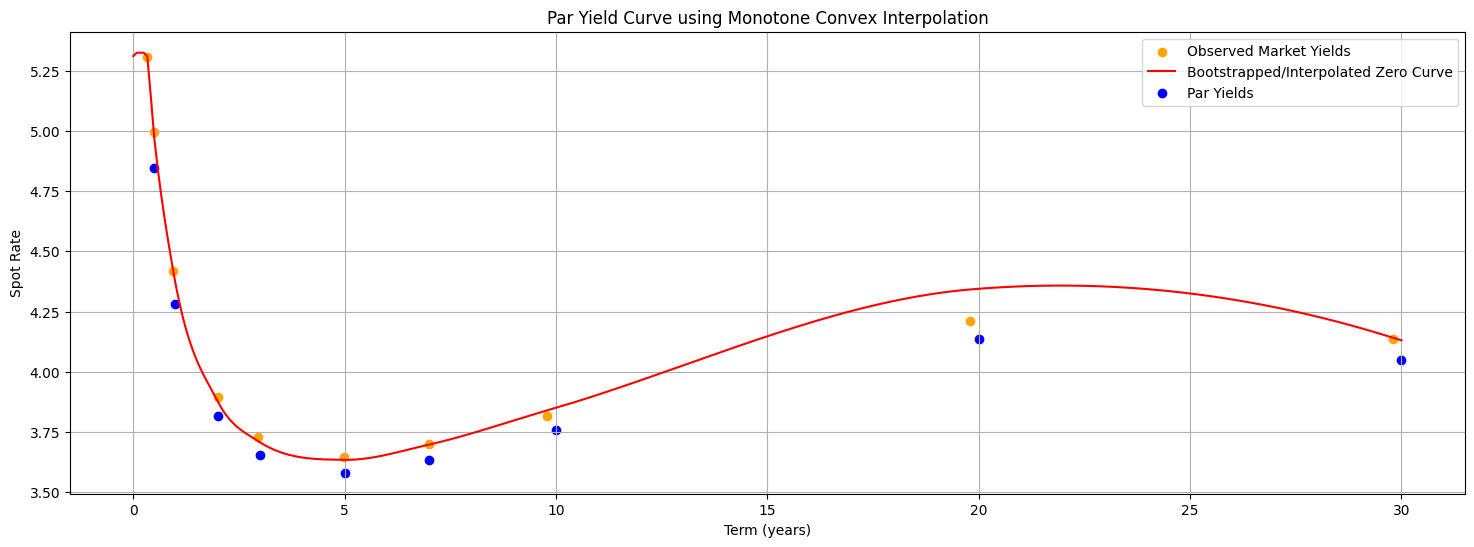

In [300]:
plt.figure(figsize=(18, 6))
plt.scatter(
    otr_df["time_to_maturity"],
    otr_df[f"{quote_type}_yield"],
    color="orange",
    label="Observed Market Yields",
)
plt.plot(
    zero_rates_df["time_to_maturity"],
    zero_rates_df["spot_rate"],
    color="red",
    label="Bootstrapped/Interpolated Zero Curve",
)
plt.scatter(
    par_rates["tenor"],
    par_rates["par_rate"],
    color="blue",
    label="Par Yields",
)
plt.xlabel("Term (years)")
plt.ylabel("Spot Rate")
plt.title("Par Yield Curve using Monotone Convex Interpolation")
plt.legend()
plt.grid(True)
plt.show()